Simple Segmentation Net

In [14]:
# overview
Scans = {
    0: 'FLAIR',
    1: 'T1w',
    2: 't1gd',
    3: 'T2w'}

Labels = {
    0: 'background',
    1: 'edema',
    2: 'non-enhancing tumor',
    3: 'enhancing tumour'}

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch

torch.manual_seed(0)

Data Loading

In [7]:
# PATH
dataset_path = '/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/'

train_data = BraTS_TrainingDataset(dataset_path)

trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=2, shuffle=True, num_workers=0)

train_iter = iter(trainloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

# plot_batch(sample_batch, num_rows=2, height=75)

/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/imagesTr
/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/labelsTr
torch.Size([2, 4, 155, 240, 240])
torch.Size([2, 155, 240, 240])


Create the model

In [231]:
class SmallSegNet(nn.Module):
    
    def __init__(self, in_channels=4, num_classes=4, img_height=5, img_width=5):
        super(SmallSegNet, self).__init__()
        self.sm = nn.Softmax(dim=1)
        self.layers = nn.Sequential(
        
        # decrease x,y and increase channels
            # Conv
            nn.Conv3d(in_channels,8,2,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # change number of channels
            # 1x1 Conv
            nn.Conv3d(8,8,1,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # increase x,y and decrease channels
            # Transpose-Conv
            nn.ConvTranspose3d(8, num_classes, 2, stride=1, padding=0)
        )
    
    def forward(self, x):
        x = torch.FloatTensor(x)
        x = self.layers(x)
        # x = self.sm(x)
        # Skip Softmax because Torch CrossEntropyLoss
        # takes logits and already applies Softmax.
        return x

# summary
print(SmallSegNet())

model = SmallSegNet(in_channels=4, num_classes=4, img_height=240, img_width=240)

SmallSegNet(
  (sm): Softmax(dim=1)
  (layers): Sequential(
    (0): Conv3d(4, 8, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(8, 4, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  )
)


In [195]:
x = sample_batch['image']
print(x.shape)

y_hat = model.forward(x)
y_hat.shape

torch.Size([2, 4, 155, 240, 240])


torch.Size([2, 4, 155, 240, 240])

torch.Size([2, 155, 240, 240])


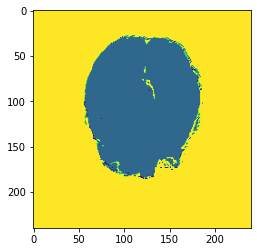

In [210]:
probs, out = torch.max(y_hat, dim=1)
print(out.shape)
plt.imshow(out[0, 70, :, :])

Crossentropy Loss

In [211]:
criterion = nn.CrossEntropyLoss()

In [226]:
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)
print(y_hat.shape)

loss = criterion(y_hat, sample_batch['label'].long())
loss

torch.Size([2, 4, 155, 240, 240])
torch.Size([2, 155, 240, 240])
torch.Size([2, 4, 155, 240, 240])


tensor(6.3037, grad_fn=<NllLoss2DBackward0>)

Training loop: Overfit to one sample

In [227]:
optim = torch.optim.Adam(model.parameters(), lr=0.1)

In [228]:
# training loop
epochs = 10
losses = []
for epoch in range(epochs):
    # get output
    voxel_logits_batch = model.forward(sample_batch['image'])
    
    # get loss
    loss = criterion(voxel_logits_batch, sample_batch['label'].long())
    losses.append(loss)
    
    # backprop loss
    optim.zero_grad()
    loss.backward()
    optim.step()

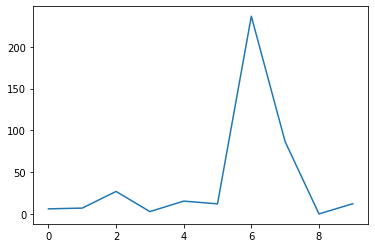

In [229]:
losses_array = [l.detach().numpy() for l in losses]
plt.plot(losses_array)

Predict

In [230]:
voxel_logits_batch = model.forward(sample_batch['image'])

In [237]:
voxel_probs_batch = model.sm(voxel_logits_batch)
voxel_probs_batch.shape

torch.Size([2, 4, 155, 240, 240])

In [240]:
probs, out = torch.max(voxel_probs_batch, dim=1)
out.shape

torch.Size([2, 155, 240, 240])

prediction:


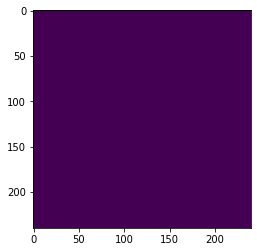

In [253]:
print('prediction:')
plt.imshow(out[0, 70, :, :])

label:


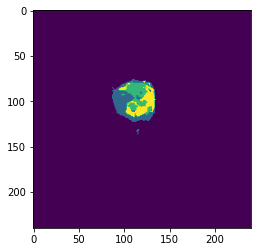

In [254]:
print('label:')
plt.imshow(sample_batch['label'][0, 70, :, :])

<Figure size 432x288 with 0 Axes>

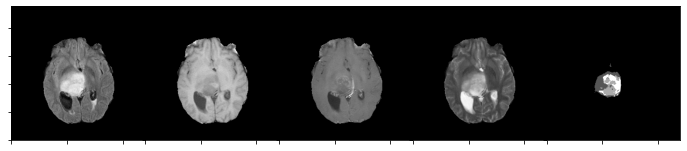

In [255]:
plot_batch(sample_batch, 1)